In [1]:
#libraries
!pip install tensorflow-gpu

     |████████████████████████████████| 394.3MB 46kB/s 


In [2]:
!nvidia-smi

Thu Feb 11 08:27:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

#### Encoder architecture

In [4]:
input_img = Input(shape=(256, 256, 3))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [5]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

#### Decoder Architecture

In [6]:
input_img = Input(shape=(256, 256, 3))
l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
             activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(3, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

autoencoder = Model(input_img, decoded)

autoencoder_hfenn = Model(input_img, decoded)

In [7]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [8]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [25]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np

def train_batches(just_load_dataset=False):

    batches = 8 # Number of images to have at the same time in a batch

    batch = 0 # Number if images in the current batch (grows over time and then resets for each batch)
    batch_nb = 0 # Batch current index

    max_batches = -1 # If you want to train only on a limited number of images to finish the training even faster.
    
    ep = 4 # Number of epochs

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset
    
    for root, dirnames, filenames in os.walk("/content/drive/MyDrive/Colab material/Data/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: # If we limit the number of batches, just return earlier
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256)) # Resize the image so that every image is the same size
                    x_train_n.append(image_resized) # Add this image to the high res dataset
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0)) # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15,
                            verbose=1)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

In [26]:
x_train_n, x_train_down = train_batches(just_load_dataset=True)

In [28]:
x_train_down.shape

(8, 256, 256, 4)

In [29]:
encoded_imgs = encoder.predict(x_train_n)

In [31]:
encoded_imgs.shape

(8, 64, 64, 256)

In [33]:
# We clip the output so that it doesn't produce weird colors
sr1 = np.clip(autoencoder.predict(x_train_n), 0.0, 1.0)

In [36]:
sr1.shape

(8, 256, 256, 3)

In [37]:


image_index = 6



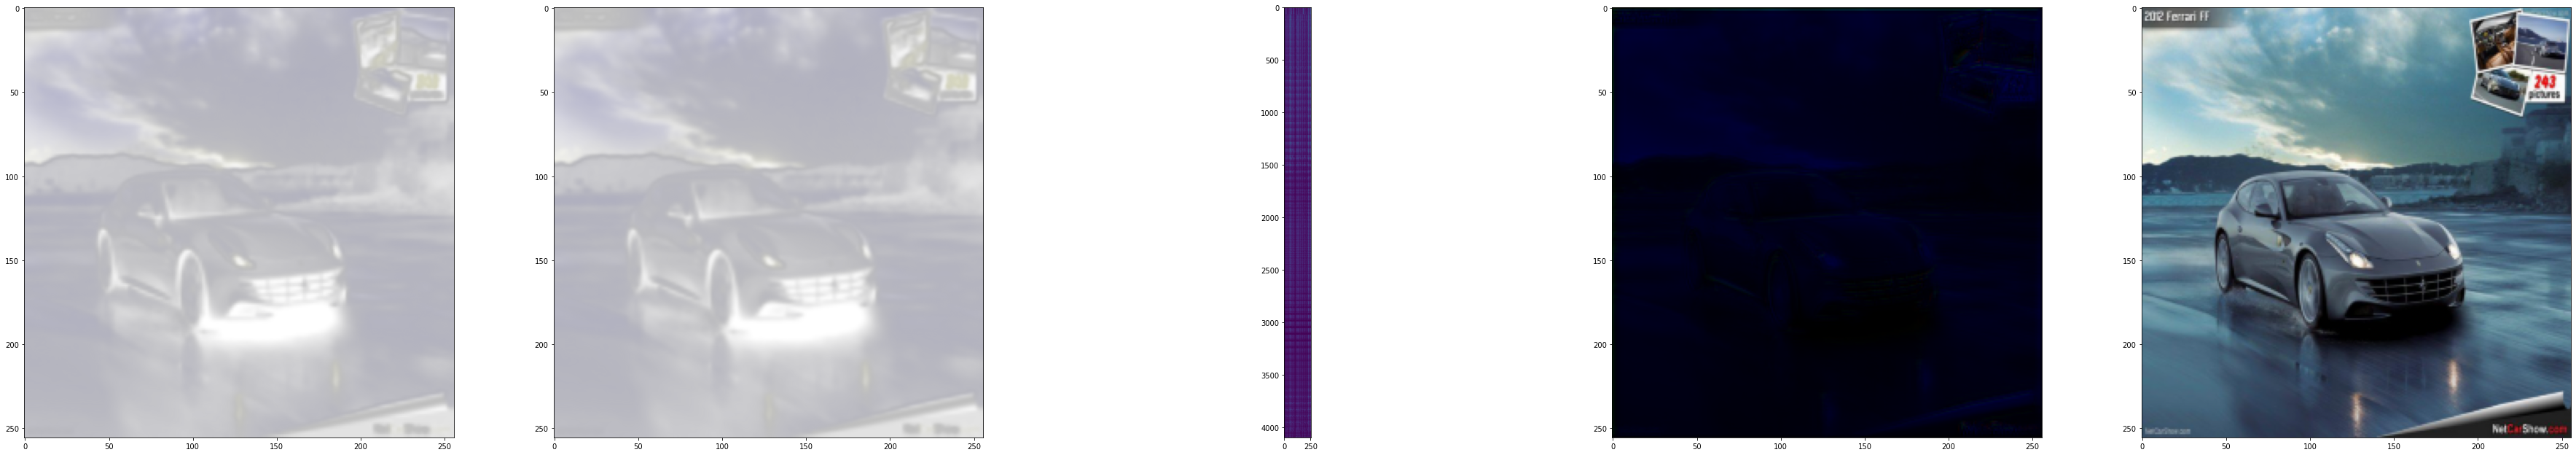

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()

